In [5]:
pip install nltk


  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
     -------------------------------------- 267.7/267.7 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
pip install spacy

     --------------------------------------- 11.8/11.8 MB 10.9 MB/s eta 0:00:00
  Using cached spacy_legacy-3.0.10-py2.py3-none-any.whl (21 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
     ---------------------------------------- 91.9/91.9 kB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 10.0 MB/s eta 0:00:00
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
     -------------------------------------- 477.5/477.5 kB 7.4 MB/s eta 0:00:00
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 10.0 MB/s eta 0:00:00
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached smart_open-6.2.0-py3-none-any.whl (58 kB)
     ---------------------------------------- 7.0/7.0 MB 11.5 MB/s eta 0:00:

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import spacy

In [6]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier

Data engineering - creating element wise data for each score

In [7]:
data = pd.read_csv('mu_data.csv')
data.head()

,id,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score
0,1,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0
1,2,12522.0,42.0,Having a difficulty with his Divided Line. Th...,#deductivearg,2.0
2,3,12522.0,44.0,"How can one know if he's in the cave or not, i...",#objectivemorality,3.0
3,4,12522.0,237.0,S: the hierarchy of the chart we filled out at...,#objectivemorality,3.0
4,5,12522.0,239.0,It is difficult to grasp how to apply Plato's ...,#objectivemorality,3.0


In [8]:
data = data.rename(columns={
    'Polls ID': 'poll_id',
    'Assessment reports Student ID': 'student_id',
    'Poll Responses Response':'response',
    'Assessment reports Hashtag':'HC',
    'Assessment reports Score':'score'})
data.head()

,id,poll_id,student_id,response,HC,score
0,1,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0
1,2,12522.0,42.0,Having a difficulty with his Divided Line. Th...,#deductivearg,2.0
2,3,12522.0,44.0,"How can one know if he's in the cave or not, i...",#objectivemorality,3.0
3,4,12522.0,237.0,S: the hierarchy of the chart we filled out at...,#objectivemorality,3.0
4,5,12522.0,239.0,It is difficult to grasp how to apply Plato's ...,#objectivemorality,3.0


In [100]:
deduction = data[data['HC'] == '#deduction']
deduction.shape
deduction.head()

,id,poll_id,student_id,response,HC,score
263,264,19704.0,283.0,Freshwater economists would state that the bub...,#deduction,4.0
626,627,20862.0,625.0,The most important moment of class for me was ...,#deduction,3.0
627,628,20862.0,634.0,"Free choice can be manipulated with language, ...",#deduction,3.0
628,629,20862.0,653.0,The activities regarding quantifiers placed a ...,#deduction,3.0
629,630,20862.0,673.0,Applying quantifiers that eliminate the ambigu...,#deduction,3.0


In [7]:
"""
Rubric for #deduction
1. Accurately applies and analyzes deductive reasoning with clear and detailed explanation
2. accurately identifies premises and conclusions and justifies the identification
3. provides a detailed, well-justified evaluation of the relationships among propositions with easy to follow steps
4. accurately distinguishes between validity and soundness and explains the meaning of each in the given context
5. provides a detailed, well justified evaluation of the validity or soundness
6. accurately and effectively applies deductive techniques to a complex, sophisticated derivation.

Assuming that a person gets a 4 if they applied at least half of these, 3 if they applied 2, 2 if they applied 1 
"""

'\nRubric for #deduction\n1. Accurately applies and analyzes deductive reasoning with clear and detailed explanation\n2. accurately identifies premises and conclusions and justifies the identification\n3. provides a detailed, well-justified evaluation of the relationships among propositions with easy to follow steps\n4. accurately distinguishes between validity and soundness and explains the meaning of each in the given context\n5. provides a detailed, well justified evaluation of the validity or soundness\n6. accurately and effectively applies deductive techniques to a complex, sophisticated derivation.\n\nAssuming that a person gets a 4 if they applied at least half of these, 3 if they applied 2, 2 if they applied 1 \n'

In [98]:
deduction = deduction.drop(['id', 'student_id', 'HC'], axis = 1)


In [44]:
total_elements = 6
rubric = np.zeros((2977, 6))
i = 0
for score in deduction['score']:
    if score == 4.0:
        #gets a 4 if they met 4, 5, or all 6 of the elements
        c = np.random.randint(4,7)
        elemets = [0]*(total_elements-c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
    elif score == 3.0:
        #gets a 3 if they met 2 or 3 of the elements
        c = np.random.randint(2, 4)
        elemets = [0]*(total_elements - c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
        rubric[i] = elemets
    elif score == 2.0:
        #gets a 2 if they met 1 or 2 of the elements
        c = np.random.randint(1, 3)
        elemets = [0]*(total_elements-c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
        rubric[i] = elemets
    i += 1

#np.random.randint(2, size = (10, 6))


In [57]:
rubric_elements = pd.DataFrame(rubric)
rubric_elements = rubric_elements.rename(columns={
    0: 'E1',
    1: 'E2',
    2: 'E3',
    3: 'E4',
    4: 'E5',
    5: 'E6'})
rubric_elements.head()

,E1,E2,E3,E4,E5,E6
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0


In [68]:
deduction = deduction.reset_index()
deduction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   level_0   2977 non-null   int64  
 1   index     2977 non-null   int64  
 2   poll_id   2977 non-null   float64
 3   response  2977 non-null   object 
 4   score     2977 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 116.4+ KB


In [71]:
 deduction = deduction.join(rubric_elements, how='right') 

Training a model

In [75]:
X = deduction[['E1', 'E2', 'E3', 'E4', 'E5', 'E6']].values
y = deduction['score'].values

#splitting the data into testing and training data to test for accuracy 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 35)

In [78]:
model = SVC(C = 8)
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f'Support Vector Classifier test accuracy {test_score:.3}')

Support Vector Classifier test accuracy 0.858


#### Hyperparameter tuning

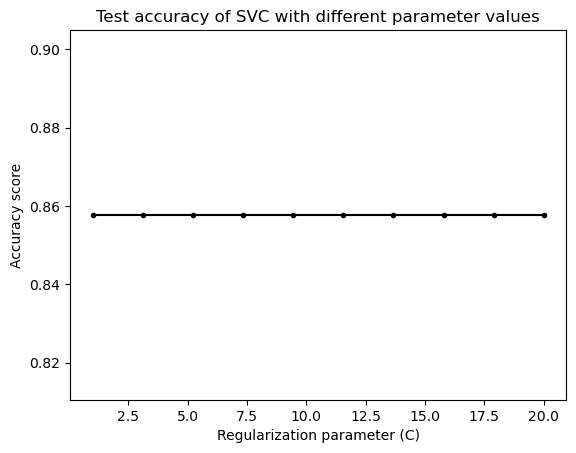

In [79]:
C = np.linspace(1, 20, 10)
scores = []

for c in C:
    model = SVC(C = c)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    scores.append(test_score)
    
plt.figure()
plt.plot(C, scores, marker = '.', color = 'black')
plt.ylabel('Accuracy score')
plt.xlabel('Regularization parameter (C)')
plt.title('Test accuracy of SVC with different parameter values')
plt.show()

In [81]:
#tuning for only one parameter doesn't give us very credible results so I use Cross validation to tune for several paramters.
kf = KFold(n_splits = 5, shuffle = True, random_state=43)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm = SVC()
svm_cv = GridSearchCV(svm, param_grid, cv = kf)
svm_cv.fit(X_train, y_train)
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'} 0.8812792809060903


Trying other models

In [92]:
models = {'KNN': KNeighborsClassifier(n_neighbors = 8), 'Random Forest': RandomForestClassifier(), 'SVC': SVC()}
#calculating the inital model accuracy for each model, before parameter tuning 
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'{name} test accuracy {test_score:.3}')

KNN test accuracy 0.828
Random Forest test accuracy 0.858
SVC test accuracy 0.858


In [93]:
#corss validation
kf = KFold(n_splits = 5, shuffle = True, random_state=43)
param_grid = {'leaf_size': np.arange(1, 50), 'n_neighbors':np.arange(1, 30), 'p':[1,2]}

KNN = KNeighborsClassifier()
KNN_cv = GridSearchCV(KNN, param_grid, cv = kf)
KNN_cv.fit(X_train, y_train)
print(KNN_cv.best_params_, KNN_cv.best_score_)

{'leaf_size': 14, 'n_neighbors': 7, 'p': 1} 0.8718702661490154


## Similarity index based clasification

In [41]:
rubrics_dict = {"#algorithms": ["Identifies an appropriate algorithmic strategy and justifies the choice", " accurately implements or interprets an algorithm, using code if appropriate, with detailed, clear, and efficient steps", " provides thorough explanation of code (e.g. comments)", " effectively implements and explains a complex, sophisticated algorithm."],
                "#confidenceintervals": ["Accurately interprets the meaning of a confidence interval with well justified reasoning", " accurately calculates a confidence interval for a given sample and population characteristic with clear and detailed steps", " accurately applies a confidence interval for estimating population parameter with an explained interpretation", " applies confidence intervals to a sophisticated, complex inference problem."],
                "#correlation": ["Accurately applies correlation to interpret the relationship between variables with clear and appropriately detailed explanation", " recognizes and effectively explains the difference between correlation and causation within the given context", " computes or interprets a measure of correlation and provides a clear and detailed and explanation within the given context", " identifies nontrivial extraneous variables that could be the underlying cause of the correlation and effectively explains the potential links."],
                "#deduction": ["Accurately applies and analyzes deductive reasoning with clear and detailed explanation", " accurately identifies premises and conclusions and justifies the identification", " provides a detailed, well-justified evaluation of the relationships among propositions with easy to follow steps", " accurately distinguishes between validity and soundness and explains the meaning of each in the given context", " provides a detailed, well justified evaluation of the validity or soundness", " accurately and effectively applies deductive techniques to a complex, sophisticated derivation."],
                "#descriptivestats": ["Chooses an appropriate descriptive statistic and justifies the choice", " accurately calculates a descriptive statistic with clear detailed steps", " provides a well reasoned and justified interpretation of the statistic", " correctly creates a histogram for the data and provides detailed interpretation", " applies multiple descriptive statistics to create a robust analysis of the data."],
                "#distributions": ["Accurately identifies an appropriate distribution in the given context and justifies the choice", " accurately describes features or characteristics of a distribution, including relevant calculations, with an appropriate level of detail", " correctly considers the effects of the underlying distribution when making inferences from samples, including required assumptions, and clearly explains the consequences and limitations", " accurately recognizes when regression to the mean applies in a given context and describes measures to mitigate the effect."],
                "#modeling": ["Accurately identifies an existing model that can describe a system, explain patterns in empirical data, test a theory, or make predictions and provides a clear justification for the choice", " accurately determines the relevant aspects of a model in a given context and provides a clear justification for the choice", " effectively develops a model appropriate to the context and provides a clear, detailed explanation", " accurately interprets and clearly explains the results or implications of applying a model", " accurately evaluates the effectiveness of an application of a model and provides a well-supported critique or suggests a non-trivial improvement."],
                "#probability": ["Accurately applies appropriate probabilities with well justified reasoning", " accurately interprets probabilities with well justified reasoning", " accurately distinguishes between different interpretations of probability and provides a detailed explanation", " accurately calculates an appropriate probability with clear detailed steps", " accurately and effectively applies an appropriate probability or interprets a probability in a complex or sophisticated context."],
                "#regression": ["Accurately constructs or interprets a regression model with a well-justified explanation of the relation between dependent and independent variables", " accurately computes or interprets the regression equation with clear and detailed explanation", " accurately computes or interprets the coefficient of determination with clear and detailed explanation", " accurately uses a regression model for prediction and effectively explains the result in the given context", " effectively implements and interprets a complex, sophisticated regression model."],
                "#significance": ["Accurately applies or interprets an appropriate significance test or measure of significance with well justified reasoning", " accurately distinguishes between type I and type II errors and explains the potential consequences", " accurately distinguishes between practical and statistical significance and explains the difference within a given context", " accurately and effectively calculates or interprets the results of a significance test or measure in a subtle or complex scenario."]}


#### 1. Creating similarity scores for each element

In [42]:
def HC_to_score(df, rubric):
    """
    A function to create similarity scores for each element in the rubric. Goes through all the HC's specified and finds a similarity index 
    for the rubric elements for each response in that HC

    input:
        df: dataframe - database of the responses
        rubric: dict - dictionary of the HCs and list of rubric elements
    returns:
        sim_scores: dict - a dictionary of HCs and a list of similarity scores for each response for an HCs (values are lists of lists)

    """
    nlp = spacy.load('en_core_web_lg')
    sim_scores = {}
    for key, value in rubrics_dict.items():
        df_a = df[df['HC'] == key]
        sim = []
        for res in df_a['response']:
            sim_per_res = []
            response_stats = []
            for el in value:
                response = nlp(res)
                element = nlp(el)
                s = response.similarity(element)
                #each score stored in the list for that response 
                sim_per_res.append(s)
            #the list of similarity scores for each response 
            sim.append(sim_per_res)
        sim_scores[key] = sim
    return sim_scores


HC_to_score(data, rubrics_dict)

        


C:\Users\saai2\AppData\Local\Temp\ipykernel_21824\191793433.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  s = response.similarity(element)


{'#algorithms': [[0.7749812908473547,
   0.8154666223752516,
   0.4653184149920776,
   0.8792423445842159],
  [0.8126722441388454,
   0.8639837207851315,
   0.46310281050172275,
   0.874993643910508],
  [0.78548383042826,
   0.8370536100545006,
   0.36517868967403705,
   0.882550169913237],
  [0.7079545751609368,
   0.8299744676212348,
   0.27218371802355545,
   0.7920267412758305],
  [0.7752395137459892,
   0.8371209408780294,
   0.4159230837979436,
   0.8457908463861602],
  [0.8706808606734809,
   0.8822213681248744,
   0.5101829449296543,
   0.884213690342968],
  [0.8564428712861534,
   0.8770525295471678,
   0.5231680330720152,
   0.9147922980959945],
  [0.7329022706596952,
   0.8612675667153927,
   0.33292042546659817,
   0.8296531163528202],
  [0.8564126055735273,
   0.8930097153133243,
   0.382030576391612,
   0.884441114832346],
  [0.7571053548703593,
   0.8382738549755893,
   0.5325001070707241,
   0.8576172191010801],
  [0.7298856120888373,
   0.8433112592719032,
   0.6043114

In [69]:
element_scores = HC_to_score(data, rubrics_dict)


C:\Users\saai2\AppData\Local\Temp\ipykernel_21824\191793433.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  s = response.similarity(element)


#### 2. Determining if an element is present of not

In [79]:

def element_scores_binary(x, t):
    """
    A function to determine whether an element is present or not given their similarity score

    x : array of similarity scores
    t : threshold for presence/absence

    returns:
        scores: 2d array of binary scores 
    """
    scores = np.zeros((len(x), len(x[0])))
    for i in range(len(x)):
        for j in range(len(x[0])):
            if x[i][j] > t:
                scores[i][j] = 1
    return scores

binary_scores_deduction = element_scores_binary(element_scores['#deduction'], 0.85)


In [143]:
def predicting_scores(x, t, HC):
    """
    A function that creates the training data for the model and runs the model to find an accuracy score

    input:
        x: dict - dictionary of HCs with list of similarity scores
        t: int - integer value of threshold 
        HC: string - HC to analyze
    """
    binary_scores = element_scores_binary(x[HC], t)
    binary_scores_df = pd.DataFrame(binary_scores)
    HC_df = data[data['HC'] == HC].reset_index()
    HC_df = HC_df.join(binary_scores_df, how = "right")

    X = HC_df[list(np.arange(0, len(binary_scores[0])))].values
    y = HC_df['score'].values

    #splitting the data into testing and training data to test for accuracy 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 35)

    model = SVC(C = 1, gamma = 0.1, kernel = 'sigmoid')
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    #print(f'Support Vector Classifier test accuracy {test_score:.3}')
    return(test_score, HC_df)




In [144]:
def tuning(rubric, x):
    best_accuracy = {}
    t = np.linspace(0.4, 1, 50)
    for HC in rubric.keys():
        accuracy = []
        for i in t:
            a, HC_df = predicting_scores(x, i, HC)
            accuracy.append(a)
        best_accuracy[HC] = (list(t)[accuracy.index(max(accuracy))], max(accuracy))
    return best_accuracy

tuning(rubrics_dict, element_scores)

{'#algorithms': (0.47346938775510206, 0.5698924731182796),
 '#confidenceintervals': (0.8285714285714285, 0.5363128491620112),
 '#correlation': (0.4, 0.6015625),
 '#deduction': (0.4, 0.5637583892617449),
 '#descriptivestats': (0.4, 0.6818181818181818),
 '#distributions': (0.7061224489795919, 0.504424778761062),
 '#modeling': (0.7551020408163265, 0.609504132231405),
 '#probability': (0.7673469387755102, 0.4961038961038961),
 '#regression': (0.8163265306122449, 0.550561797752809),
 '#significance': (0.4, 0.5352112676056338)}

In [138]:
predicting_scores(element_scores, 0.6, '#algorithms')


({'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}, 0.5565466082759853)

In [127]:
t = np.linspace(0.2, 1, 100)
accuracies = []

for i in t:
    accuracy, df = predicting_scores(element_scores, i, '#modeling')
    accuracies.append(accuracy)

max(accuracies)
# plt.figure()
# plt.plot(t, accuracies)
# plt.show()

0.6136363636363636